# <center>MobileNet - Pytorch

# Step 1: Prepare data

In [3]:
# MobileNet-Pytorch
import argparse 
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
#from mobilenets import mobilenet

use_cuda = torch.cuda.is_available()
use_cudause_cud  = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [4]:
# Train, Validate, Test. Heavily inspired by Kevinzakka https://github.com/kevinzakka/DenseNet/blob/master/data_loader.py

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

valid_size=0.1

# define transforms
valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])


# load the dataset
train_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=train_transform)

valid_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=valid_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train)) #5w张图片的10%用来当做验证集


np.random.seed(42)# 42
np.random.shuffle(indices) # 随机乱序[0,1,...,49999]

train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx) # 这个很有意思
valid_sampler = SubsetRandomSampler(valid_idx)

###################################################################################
# ------------------------- 使用不同的批次大小 ------------------------------------
###################################################################################

show_step=2  # 批次大，show_step就小点
max_epoch=80  # 训练最大epoch数目

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=256, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=256, sampler=valid_sampler)


test_transform = transforms.Compose([
    transforms.ToTensor(), normalize
])

test_dataset = datasets.CIFAR10(root="data", 
                                train=False, 
                                download=True,transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=256, 
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Step 2: Model Config

# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 3
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs,out_channel,in_Channel]
        w = self.conv1D(w)
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
        # -------------- softmax ---------------------------
        #print(w.shape)
        w = w.view(w.shape[0],w.shape[1],w.shape[2],1,1)
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
        out=out.view(out.shape[0],1,out.shape[1],out.shape[2],out.shape[3])
        #print("x size:",out.shape)
        
        out=out*w
        #print("after fusion x size:",out.shape)
        out=out.sum(dim=2)
        
        out = F.relu(self.bn2(out))
        
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]

    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            out_planes = x if isinstance(x, int) else x[0]
            stride = 1 if isinstance(x, int) else x[1]
            layers.append(Block(in_planes, out_planes, stride))
            in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [5]:
# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F

class Block_Attention_HALF(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention_HALF, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        #------------------------ 一半 ------------------------------
        self.conv2 = nn.Conv2d(in_planes, int(out_planes*0.125), kernel_size=1, stride=1, padding=0, bias=False)
        
        #------------------------ 另一半 ----------------------------
        one_conv_kernel_size = 17 # [3,7,9]
        self.conv1D= nn.Conv1d(1, int(out_planes*0.875), one_conv_kernel_size, stride=1,padding=8,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        #------------------------------------------------------------
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu6(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        #w=w[0]-torch.mean(w[0])
        w=torch.randn(w[0].shape).cuda()*0.01
        a=torch.randn(1).cuda()*0.1
        if a>0.37:
            print(w.shape)
            print(w)
        
        w=w.view(1,1,in_channel)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel//2,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel//2,in_Channel]
        
        #-------------------------------------
        w = 0.1*F.tanh(w) # [-0.5,+0.5]
        
        if a>0.37:
            print(w.shape)
            print(w)
            
        # [bs=1,out_channel//2,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel//2,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out_1=self.conv2(out)
        out_2=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)
        out=torch.cat([out_1,out_2],1)
        
        # ----------------------- 试一试不要用relu -------------------------------
        out = F.relu6(self.bn2(out))
        
        return out

class Block_Attention(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 17 # [3,7,9]
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=8,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        
        w=w[0]
        
        w=w.view(1,1,in_channel)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel,in_Channel]
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
         # [bs=1,out_channel,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)

        out = F.relu(self.bn2(out))
        
        return out


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]
    
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), [1024,1]]
    cfg = [64, (128,2), 128, 256, 256, (512,2), 512, [512,1], [512,1],[512,1], [512,1], [1024,1], [1024,1]]
    
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            if isinstance(x, int):
                out_planes = x
                stride = 1 
                layers.append(Block(in_planes, out_planes, stride))
            elif isinstance(x, tuple):
                out_planes = x[0]
                stride = x[1]
                layers.append(Block(in_planes, out_planes, stride))
            # AC层通过list存放设置参数
            elif isinstance(x, list):
                out_planes= x[0]
                stride = x[1] if len(x)==2 else 1
                layers.append(Block_Attention_HALF(in_planes, out_planes, stride))   
            else:
                pass
            
            in_planes = out_planes
            
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [6]:
# From https://github.com/Z0m6ie/CIFAR-10_PyTorch
#model = mobilenet(num_classes=10, large_img=False)

# From https://github.com/kuangliu/pytorch-cifar 
if torch.cuda.is_available():
    model=MobileNet(10).cuda()
else:
    model=MobileNet(10)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
#scheduler = StepLR(optimizer, step_size=70, gamma=0.1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,70,75,80], gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [7]:
# Implement validation
def train(epoch):
    model.train()
    #writer = SummaryWriter()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        correct = 0
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()
        
        loss = criterion(output, target)
        loss.backward()
        accuracy = 100. * (correct.cpu().numpy()/ len(output))
        optimizer.step()
        if batch_idx % 5*show_step == 0:
#             if batch_idx % 2*show_step == 0:
#                 print(model.layers[1].conv1D.weight.shape)
#                 print(model.layers[1].conv1D.weight[0:2][0:2])
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1=open("Cifar10_INFO.txt","a+")
#             f1.write("\n"+'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1.close()
            
            #writer.add_scalar('Loss/Loss', loss.item(), epoch)
            #writer.add_scalar('Accuracy/Accuracy', accuracy, epoch)
    scheduler.step()

In [8]:
def validate(epoch):
    model.eval()
    #writer = SummaryWriter()
    valid_loss = 0
    correct = 0
    for data, target in valid_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        valid_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()

    valid_loss /= len(valid_idx)
    accuracy = 100. * correct.cpu().numpy() / len(valid_idx)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         valid_loss, correct, len(valid_idx),
#         100. * correct / len(valid_idx)))
#     f1.close()
    #writer.add_scalar('Loss/Validation_Loss', valid_loss, epoch)
    #writer.add_scalar('Accuracy/Validation_Accuracy', accuracy, epoch)
    return valid_loss, accuracy

In [9]:
# Fix best model

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct.cpu().numpy() / len(test_loader.dataset)))
#     f1.close()

In [10]:
def save_best(loss, accuracy, best_loss, best_acc):
    if best_loss == None:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
        
    elif loss < best_loss and accuracy > best_acc:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
    return best_loss, best_acc

In [11]:
# Fantastic logger for tensorboard and pytorch, 
# run tensorboard by opening a new terminal and run "tensorboard --logdir runs"
# open tensorboard at http://localhost:6006/
from tensorboardX import SummaryWriter
best_loss = None
best_acc = None

import time 
SINCE=time.time()

for epoch in range(max_epoch):
    train(epoch)
    
    loss, accuracy = validate(epoch)
    best_loss, best_acc = save_best(loss, accuracy, best_loss, best_acc)
    
    NOW=time.time() 
    DURINGS=NOW-SINCE
    SINCE=NOW
    print("the time of this epoch:[{} s]".format(DURINGS))
    
    if epoch>=10 and (epoch-10)%2==0:
        test(epoch)
    
# writer = SummaryWriter() 
# writer.export_scalars_to_json("./all_scalars.json")

# writer.close()

#---------------------------- Test ------------------------------
test(epoch)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.300408, Accuracy: 9.77
Train Epoch: 0 [1280/50000 (3%)]	Loss: 2.346795, Accuracy: 12.11
Train Epoch: 0 [2560/50000 (6%)]	Loss: 2.350471, Accuracy: 9.77
Train Epoch: 0 [3840/50000 (9%)]	Loss: 2.332051, Accuracy: 13.67
Train Epoch: 0 [5120/50000 (11%)]	Loss: 2.335454, Accuracy: 10.55
Train Epoch: 0 [6400/50000 (14%)]	Loss: 2.269003, Accuracy: 13.67
Train Epoch: 0 [7680/50000 (17%)]	Loss: 2.314678, Accuracy: 10.94
Train Epoch: 0 [8960/50000 (20%)]	Loss: 2.366590, Accuracy: 11.33
Train Epoch: 0 [10240/50000 (23%)]	Loss: 2.214101, Accuracy: 16.80
Train Epoch: 0 [11520/50000 (26%)]	Loss: 2.297173, Accuracy: 7.42
Train Epoch: 0 [12800/50000 (28%)]	Loss: 2.269968, Accuracy: 12.89
Train Epoch: 0 [14080/50000 (31%)]	Loss: 2.163666, Accuracy: 16.41
Train Epoch: 0 [15360/50000 (34%)]	Loss: 2.212608, Accuracy: 12.11
Train Epoch: 0 [16640/50000 (37%)]	Loss: 2.338141, Accuracy: 13.28
Train Epoch: 0 [17920/50000 (40%)]	Loss: 2.210284, Accuracy: 17.97
Train Epoch: 

Train Epoch: 3 [14080/50000 (31%)]	Loss: 1.484625, Accuracy: 43.75
Train Epoch: 3 [15360/50000 (34%)]	Loss: 1.355417, Accuracy: 43.75
Train Epoch: 3 [16640/50000 (37%)]	Loss: 1.473049, Accuracy: 44.14
Train Epoch: 3 [17920/50000 (40%)]	Loss: 1.366236, Accuracy: 46.09
Train Epoch: 3 [19200/50000 (43%)]	Loss: 1.468556, Accuracy: 44.53
Train Epoch: 3 [20480/50000 (45%)]	Loss: 1.426813, Accuracy: 48.83
Train Epoch: 3 [21760/50000 (48%)]	Loss: 1.496700, Accuracy: 41.80
Train Epoch: 3 [23040/50000 (51%)]	Loss: 1.545534, Accuracy: 45.31
Train Epoch: 3 [24320/50000 (54%)]	Loss: 1.410491, Accuracy: 48.44
Train Epoch: 3 [25600/50000 (57%)]	Loss: 1.370763, Accuracy: 52.73
Train Epoch: 3 [26880/50000 (60%)]	Loss: 1.270838, Accuracy: 50.78
Train Epoch: 3 [28160/50000 (62%)]	Loss: 1.409195, Accuracy: 48.05
Train Epoch: 3 [29440/50000 (65%)]	Loss: 1.366037, Accuracy: 50.00
Train Epoch: 3 [30720/50000 (68%)]	Loss: 1.343167, Accuracy: 51.17
Train Epoch: 3 [32000/50000 (71%)]	Loss: 1.364219, Accuracy: 5

Train Epoch: 6 [26880/50000 (60%)]	Loss: 0.952367, Accuracy: 66.41
Train Epoch: 6 [28160/50000 (62%)]	Loss: 0.977541, Accuracy: 68.75
Train Epoch: 6 [29440/50000 (65%)]	Loss: 0.989407, Accuracy: 67.19
Train Epoch: 6 [30720/50000 (68%)]	Loss: 0.925784, Accuracy: 67.97
Train Epoch: 6 [32000/50000 (71%)]	Loss: 0.833421, Accuracy: 73.83
Train Epoch: 6 [33280/50000 (74%)]	Loss: 0.794607, Accuracy: 67.58
Train Epoch: 6 [34560/50000 (77%)]	Loss: 0.805801, Accuracy: 69.92
Train Epoch: 6 [35840/50000 (80%)]	Loss: 0.908405, Accuracy: 71.09
Train Epoch: 6 [37120/50000 (82%)]	Loss: 0.868879, Accuracy: 68.75
Train Epoch: 6 [38400/50000 (85%)]	Loss: 0.789588, Accuracy: 71.48
Train Epoch: 6 [39680/50000 (88%)]	Loss: 0.886064, Accuracy: 69.92
Train Epoch: 6 [40960/50000 (91%)]	Loss: 0.807375, Accuracy: 73.44
Train Epoch: 6 [42240/50000 (94%)]	Loss: 0.806370, Accuracy: 73.44
Train Epoch: 6 [43520/50000 (97%)]	Loss: 0.886565, Accuracy: 66.02
Train Epoch: 6 [35000/50000 (99%)]	Loss: 0.804844, Accuracy: 7


Validation set: Average loss: 1.2110, Accuracy: 2980/5000 (59.00%)

the time of this epoch:[36.04157114028931 s]
Train Epoch: 7 [0/50000 (0%)]	Loss: 0.769965, Accuracy: 73.05
Train Epoch: 7 [1280/50000 (3%)]	Loss: 0.744194, Accuracy: 77.73
Train Epoch: 7 [2560/50000 (6%)]	Loss: 0.933713, Accuracy: 69.92
Train Epoch: 7 [3840/50000 (9%)]	Loss: 0.780614, Accuracy: 74.22
Train Epoch: 7 [5120/50000 (11%)]	Loss: 0.838597, Accuracy: 69.53
Train Epoch: 7 [6400/50000 (14%)]	Loss: 0.791540, Accuracy: 71.09
Train Epoch: 7 [7680/50000 (17%)]	Loss: 0.787363, Accuracy: 75.00
Train Epoch: 7 [8960/50000 (20%)]	Loss: 0.825960, Accuracy: 69.53
Train Epoch: 7 [10240/50000 (23%)]	Loss: 0.927589, Accuracy: 70.70
Train Epoch: 7 [11520/50000 (26%)]	Loss: 0.953999, Accuracy: 65.23
Train Epoch: 7 [12800/50000 (28%)]	Loss: 0.898679, Accuracy: 68.36
Train Epoch: 7 [14080/50000 (31%)]	Loss: 0.735158, Accuracy: 75.00
Train Epoch: 7 [15360/50000 (34%)]	Loss: 0.864028, Accuracy: 69.14
Train Epoch: 7 [16640/50000 (3

Train Epoch: 9 [42240/50000 (94%)]	Loss: 0.736989, Accuracy: 73.44
Train Epoch: 9 [43520/50000 (97%)]	Loss: 0.850650, Accuracy: 69.92
Train Epoch: 9 [35000/50000 (99%)]	Loss: 0.726563, Accuracy: 73.00

Validation set: Average loss: 0.8520, Accuracy: 3530/5000 (70.00%)

the time of this epoch:[35.89274072647095 s]
Train Epoch: 10 [0/50000 (0%)]	Loss: 0.637853, Accuracy: 79.30
Train Epoch: 10 [1280/50000 (3%)]	Loss: 0.634253, Accuracy: 77.34
Train Epoch: 10 [2560/50000 (6%)]	Loss: 0.594314, Accuracy: 78.91
Train Epoch: 10 [3840/50000 (9%)]	Loss: 0.618786, Accuracy: 76.95
Train Epoch: 10 [5120/50000 (11%)]	Loss: 0.643902, Accuracy: 78.91
Train Epoch: 10 [6400/50000 (14%)]	Loss: 0.709867, Accuracy: 77.34
Train Epoch: 10 [7680/50000 (17%)]	Loss: 0.536403, Accuracy: 81.25
Train Epoch: 10 [8960/50000 (20%)]	Loss: 0.633239, Accuracy: 78.91
Train Epoch: 10 [10240/50000 (23%)]	Loss: 0.681928, Accuracy: 79.69
Train Epoch: 10 [11520/50000 (26%)]	Loss: 0.609762, Accuracy: 79.69
Train Epoch: 10 [128

Train Epoch: 13 [2560/50000 (6%)]	Loss: 0.559496, Accuracy: 82.81
Train Epoch: 13 [3840/50000 (9%)]	Loss: 0.511870, Accuracy: 82.42
Train Epoch: 13 [5120/50000 (11%)]	Loss: 0.504972, Accuracy: 83.59
Train Epoch: 13 [6400/50000 (14%)]	Loss: 0.555370, Accuracy: 81.25
Train Epoch: 13 [7680/50000 (17%)]	Loss: 0.601964, Accuracy: 80.86
Train Epoch: 13 [8960/50000 (20%)]	Loss: 0.590027, Accuracy: 78.52
Train Epoch: 13 [10240/50000 (23%)]	Loss: 0.404632, Accuracy: 87.50
Train Epoch: 13 [11520/50000 (26%)]	Loss: 0.600298, Accuracy: 80.08
Train Epoch: 13 [12800/50000 (28%)]	Loss: 0.517185, Accuracy: 83.20
Train Epoch: 13 [14080/50000 (31%)]	Loss: 0.558493, Accuracy: 82.42
Train Epoch: 13 [15360/50000 (34%)]	Loss: 0.532255, Accuracy: 83.20
Train Epoch: 13 [16640/50000 (37%)]	Loss: 0.540378, Accuracy: 78.52
Train Epoch: 13 [17920/50000 (40%)]	Loss: 0.539496, Accuracy: 82.42
Train Epoch: 13 [19200/50000 (43%)]	Loss: 0.494481, Accuracy: 82.81
Train Epoch: 13 [20480/50000 (45%)]	Loss: 0.555967, Accu

Train Epoch: 16 [12800/50000 (28%)]	Loss: 0.534351, Accuracy: 82.42
Train Epoch: 16 [14080/50000 (31%)]	Loss: 0.440967, Accuracy: 83.59
Train Epoch: 16 [15360/50000 (34%)]	Loss: 0.552200, Accuracy: 79.69
Train Epoch: 16 [16640/50000 (37%)]	Loss: 0.459418, Accuracy: 83.59
Train Epoch: 16 [17920/50000 (40%)]	Loss: 0.477267, Accuracy: 84.77
Train Epoch: 16 [19200/50000 (43%)]	Loss: 0.515319, Accuracy: 82.03
Train Epoch: 16 [20480/50000 (45%)]	Loss: 0.443544, Accuracy: 83.20
Train Epoch: 16 [21760/50000 (48%)]	Loss: 0.441981, Accuracy: 85.55
Train Epoch: 16 [23040/50000 (51%)]	Loss: 0.504328, Accuracy: 83.98
Train Epoch: 16 [24320/50000 (54%)]	Loss: 0.522600, Accuracy: 84.38
Train Epoch: 16 [25600/50000 (57%)]	Loss: 0.526998, Accuracy: 80.08
Train Epoch: 16 [26880/50000 (60%)]	Loss: 0.445190, Accuracy: 84.77
Train Epoch: 16 [28160/50000 (62%)]	Loss: 0.489470, Accuracy: 84.77
Train Epoch: 16 [29440/50000 (65%)]	Loss: 0.589489, Accuracy: 79.69
Train Epoch: 16 [30720/50000 (68%)]	Loss: 0.5059

Train Epoch: 19 [21760/50000 (48%)]	Loss: 0.421057, Accuracy: 85.55
Train Epoch: 19 [23040/50000 (51%)]	Loss: 0.463014, Accuracy: 82.81
Train Epoch: 19 [24320/50000 (54%)]	Loss: 0.384977, Accuracy: 88.67
Train Epoch: 19 [25600/50000 (57%)]	Loss: 0.487642, Accuracy: 82.42
Train Epoch: 19 [26880/50000 (60%)]	Loss: 0.499083, Accuracy: 83.59
Train Epoch: 19 [28160/50000 (62%)]	Loss: 0.449027, Accuracy: 82.42
Train Epoch: 19 [29440/50000 (65%)]	Loss: 0.534645, Accuracy: 82.42
Train Epoch: 19 [30720/50000 (68%)]	Loss: 0.430840, Accuracy: 85.16
Train Epoch: 19 [32000/50000 (71%)]	Loss: 0.506300, Accuracy: 80.86
Train Epoch: 19 [33280/50000 (74%)]	Loss: 0.378841, Accuracy: 87.89
Train Epoch: 19 [34560/50000 (77%)]	Loss: 0.415965, Accuracy: 85.94
Train Epoch: 19 [35840/50000 (80%)]	Loss: 0.579351, Accuracy: 82.42
Train Epoch: 19 [37120/50000 (82%)]	Loss: 0.428422, Accuracy: 86.72
Train Epoch: 19 [38400/50000 (85%)]	Loss: 0.442310, Accuracy: 85.16
Train Epoch: 19 [39680/50000 (88%)]	Loss: 0.4342

Train Epoch: 22 [14080/50000 (31%)]	Loss: 0.583005, Accuracy: 80.08
Train Epoch: 22 [15360/50000 (34%)]	Loss: 0.494991, Accuracy: 82.03
Train Epoch: 22 [16640/50000 (37%)]	Loss: 0.422140, Accuracy: 84.77
Train Epoch: 22 [17920/50000 (40%)]	Loss: 0.433157, Accuracy: 85.16
Train Epoch: 22 [19200/50000 (43%)]	Loss: 0.538441, Accuracy: 80.86
Train Epoch: 22 [20480/50000 (45%)]	Loss: 0.394530, Accuracy: 87.89
Train Epoch: 22 [21760/50000 (48%)]	Loss: 0.437978, Accuracy: 86.33
Train Epoch: 22 [23040/50000 (51%)]	Loss: 0.460584, Accuracy: 85.55
Train Epoch: 22 [24320/50000 (54%)]	Loss: 0.468911, Accuracy: 85.16
Train Epoch: 22 [25600/50000 (57%)]	Loss: 0.405455, Accuracy: 85.16
Train Epoch: 22 [26880/50000 (60%)]	Loss: 0.460834, Accuracy: 83.98
Train Epoch: 22 [28160/50000 (62%)]	Loss: 0.432994, Accuracy: 86.33
Train Epoch: 22 [29440/50000 (65%)]	Loss: 0.286516, Accuracy: 90.62
Train Epoch: 22 [30720/50000 (68%)]	Loss: 0.343753, Accuracy: 89.45
Train Epoch: 22 [32000/50000 (71%)]	Loss: 0.4236

Train Epoch: 24 [11520/50000 (26%)]	Loss: 0.534723, Accuracy: 84.38
Train Epoch: 24 [12800/50000 (28%)]	Loss: 0.482134, Accuracy: 81.64
Train Epoch: 24 [14080/50000 (31%)]	Loss: 0.472910, Accuracy: 85.16
Train Epoch: 24 [15360/50000 (34%)]	Loss: 0.444062, Accuracy: 83.98
Train Epoch: 24 [16640/50000 (37%)]	Loss: 0.427637, Accuracy: 86.72
Train Epoch: 24 [17920/50000 (40%)]	Loss: 0.500976, Accuracy: 83.59
Train Epoch: 24 [19200/50000 (43%)]	Loss: 0.336319, Accuracy: 89.45
Train Epoch: 24 [20480/50000 (45%)]	Loss: 0.467755, Accuracy: 83.20
Train Epoch: 24 [21760/50000 (48%)]	Loss: 0.407786, Accuracy: 86.33
Train Epoch: 24 [23040/50000 (51%)]	Loss: 0.460780, Accuracy: 85.94
Train Epoch: 24 [24320/50000 (54%)]	Loss: 0.416650, Accuracy: 87.89
Train Epoch: 24 [25600/50000 (57%)]	Loss: 0.471517, Accuracy: 84.38
Train Epoch: 24 [26880/50000 (60%)]	Loss: 0.519712, Accuracy: 81.25
Train Epoch: 24 [28160/50000 (62%)]	Loss: 0.429231, Accuracy: 85.94
Train Epoch: 24 [29440/50000 (65%)]	Loss: 0.5174

Train Epoch: 27 [20480/50000 (45%)]	Loss: 0.413693, Accuracy: 85.16
Train Epoch: 27 [21760/50000 (48%)]	Loss: 0.383876, Accuracy: 86.33
Train Epoch: 27 [23040/50000 (51%)]	Loss: 0.434947, Accuracy: 84.77
Train Epoch: 27 [24320/50000 (54%)]	Loss: 0.502837, Accuracy: 84.38
Train Epoch: 27 [25600/50000 (57%)]	Loss: 0.363632, Accuracy: 85.94
Train Epoch: 27 [26880/50000 (60%)]	Loss: 0.384853, Accuracy: 87.11
Train Epoch: 27 [28160/50000 (62%)]	Loss: 0.383746, Accuracy: 85.55
Train Epoch: 27 [29440/50000 (65%)]	Loss: 0.361186, Accuracy: 88.28
Train Epoch: 27 [30720/50000 (68%)]	Loss: 0.339207, Accuracy: 88.28
Train Epoch: 27 [32000/50000 (71%)]	Loss: 0.468980, Accuracy: 84.38
Train Epoch: 27 [33280/50000 (74%)]	Loss: 0.446345, Accuracy: 81.25
Train Epoch: 27 [34560/50000 (77%)]	Loss: 0.386990, Accuracy: 88.28
Train Epoch: 27 [35840/50000 (80%)]	Loss: 0.410484, Accuracy: 85.55
Train Epoch: 27 [37120/50000 (82%)]	Loss: 0.384652, Accuracy: 85.94
Train Epoch: 27 [38400/50000 (85%)]	Loss: 0.4585

Train Epoch: 30 [12800/50000 (28%)]	Loss: 0.422463, Accuracy: 84.38
Train Epoch: 30 [14080/50000 (31%)]	Loss: 0.392103, Accuracy: 87.11
Train Epoch: 30 [15360/50000 (34%)]	Loss: 0.427362, Accuracy: 86.72
Train Epoch: 30 [16640/50000 (37%)]	Loss: 0.430666, Accuracy: 85.94
Train Epoch: 30 [17920/50000 (40%)]	Loss: 0.339291, Accuracy: 87.50
Train Epoch: 30 [19200/50000 (43%)]	Loss: 0.372557, Accuracy: 87.11
Train Epoch: 30 [20480/50000 (45%)]	Loss: 0.354999, Accuracy: 89.06
Train Epoch: 30 [21760/50000 (48%)]	Loss: 0.462123, Accuracy: 85.94
Train Epoch: 30 [23040/50000 (51%)]	Loss: 0.402508, Accuracy: 86.33
Train Epoch: 30 [24320/50000 (54%)]	Loss: 0.307209, Accuracy: 89.84
Train Epoch: 30 [25600/50000 (57%)]	Loss: 0.563079, Accuracy: 78.52
Train Epoch: 30 [26880/50000 (60%)]	Loss: 0.336974, Accuracy: 87.50
Train Epoch: 30 [28160/50000 (62%)]	Loss: 0.444326, Accuracy: 82.81
Train Epoch: 30 [29440/50000 (65%)]	Loss: 0.357188, Accuracy: 87.11
Train Epoch: 30 [30720/50000 (68%)]	Loss: 0.4252

Train Epoch: 33 [21760/50000 (48%)]	Loss: 0.410882, Accuracy: 84.77
Train Epoch: 33 [23040/50000 (51%)]	Loss: 0.365947, Accuracy: 85.94
Train Epoch: 33 [24320/50000 (54%)]	Loss: 0.383876, Accuracy: 85.94
Train Epoch: 33 [25600/50000 (57%)]	Loss: 0.426454, Accuracy: 84.77
Train Epoch: 33 [26880/50000 (60%)]	Loss: 0.397449, Accuracy: 86.33
Train Epoch: 33 [28160/50000 (62%)]	Loss: 0.532823, Accuracy: 81.64
Train Epoch: 33 [29440/50000 (65%)]	Loss: 0.427938, Accuracy: 85.16
Train Epoch: 33 [30720/50000 (68%)]	Loss: 0.388209, Accuracy: 86.72
Train Epoch: 33 [32000/50000 (71%)]	Loss: 0.372217, Accuracy: 87.11
Train Epoch: 33 [33280/50000 (74%)]	Loss: 0.391670, Accuracy: 85.94
Train Epoch: 33 [34560/50000 (77%)]	Loss: 0.441786, Accuracy: 84.77
Train Epoch: 33 [35840/50000 (80%)]	Loss: 0.554696, Accuracy: 81.64
Train Epoch: 33 [37120/50000 (82%)]	Loss: 0.424651, Accuracy: 85.94
Train Epoch: 33 [38400/50000 (85%)]	Loss: 0.439935, Accuracy: 88.28
Train Epoch: 33 [39680/50000 (88%)]	Loss: 0.4485

Train Epoch: 36 [32000/50000 (71%)]	Loss: 0.423780, Accuracy: 85.16
Train Epoch: 36 [33280/50000 (74%)]	Loss: 0.424238, Accuracy: 86.33
Train Epoch: 36 [34560/50000 (77%)]	Loss: 0.290989, Accuracy: 90.23
Train Epoch: 36 [35840/50000 (80%)]	Loss: 0.452155, Accuracy: 85.16
Train Epoch: 36 [37120/50000 (82%)]	Loss: 0.433737, Accuracy: 84.38
Train Epoch: 36 [38400/50000 (85%)]	Loss: 0.363444, Accuracy: 88.28
Train Epoch: 36 [39680/50000 (88%)]	Loss: 0.405966, Accuracy: 88.28
Train Epoch: 36 [40960/50000 (91%)]	Loss: 0.435839, Accuracy: 85.16
Train Epoch: 36 [42240/50000 (94%)]	Loss: 0.355557, Accuracy: 87.89
Train Epoch: 36 [43520/50000 (97%)]	Loss: 0.371369, Accuracy: 87.11
Train Epoch: 36 [35000/50000 (99%)]	Loss: 0.393317, Accuracy: 87.00

Validation set: Average loss: 0.5556, Accuracy: 4082/5000 (81.00%)

the time of this epoch:[35.32092070579529 s]

Test set: Average loss: 0.5870, Accuracy: 8119/10000 (81.19%)

Train Epoch: 37 [0/50000 (0%)]	Loss: 0.334689, Accuracy: 87.89
Train Epoch

Train Epoch: 39 [40960/50000 (91%)]	Loss: 0.405558, Accuracy: 86.72
Train Epoch: 39 [42240/50000 (94%)]	Loss: 0.367931, Accuracy: 85.55
Train Epoch: 39 [43520/50000 (97%)]	Loss: 0.372834, Accuracy: 86.33
Train Epoch: 39 [35000/50000 (99%)]	Loss: 0.374477, Accuracy: 87.00

Validation set: Average loss: 0.6900, Accuracy: 3896/5000 (77.00%)

the time of this epoch:[38.3201630115509 s]
Train Epoch: 40 [0/50000 (0%)]	Loss: 0.352569, Accuracy: 88.28
Train Epoch: 40 [1280/50000 (3%)]	Loss: 0.307484, Accuracy: 88.28
Train Epoch: 40 [2560/50000 (6%)]	Loss: 0.333475, Accuracy: 89.45
Train Epoch: 40 [3840/50000 (9%)]	Loss: 0.232116, Accuracy: 93.36
Train Epoch: 40 [5120/50000 (11%)]	Loss: 0.463064, Accuracy: 83.98
Train Epoch: 40 [6400/50000 (14%)]	Loss: 0.355716, Accuracy: 88.28
Train Epoch: 40 [7680/50000 (17%)]	Loss: 0.293382, Accuracy: 88.67
Train Epoch: 40 [8960/50000 (20%)]	Loss: 0.413278, Accuracy: 87.50
Train Epoch: 40 [10240/50000 (23%)]	Loss: 0.410744, Accuracy: 87.50
Train Epoch: 40 [1

torch.Size([512, 1, 1])
tensor(1.00000e-02 *
       [[[ 0.1953]],

        [[-0.8152]],

        [[-0.5213]],

        [[-0.0999]],

        [[ 0.1126]],

        [[-0.1156]],

        [[ 0.0558]],

        [[-1.0156]],

        [[ 0.2152]],

        [[-0.2844]],

        [[ 0.6118]],

        [[-0.6181]],

        [[-0.8276]],

        [[ 0.0807]],

        [[ 1.0605]],

        [[-0.7771]],

        [[ 1.0021]],

        [[ 0.7768]],

        [[-0.3711]],

        [[-1.3331]],

        [[ 1.1798]],

        [[ 1.1864]],

        [[-1.8723]],

        [[ 0.3508]],

        [[-1.0636]],

        [[-0.9458]],

        [[-0.4590]],

        [[ 0.0348]],

        [[ 0.1754]],

        [[ 0.5989]],

        [[-0.5621]],

        [[ 0.5046]],

        [[ 0.6838]],

        [[-0.3808]],

        [[-0.0018]],

        [[ 1.1107]],

        [[ 0.3349]],

        [[-0.0997]],

        [[-0.6989]],

        [[ 0.3103]],

        [[-1.0484]],

        [[ 0.8528]],

        [[-1.9422]],

        [

Train Epoch: 43 [2560/50000 (6%)]	Loss: 0.333781, Accuracy: 89.45
Train Epoch: 43 [3840/50000 (9%)]	Loss: 0.250496, Accuracy: 90.62
Train Epoch: 43 [5120/50000 (11%)]	Loss: 0.272057, Accuracy: 92.19
Train Epoch: 43 [6400/50000 (14%)]	Loss: 0.346207, Accuracy: 88.28
Train Epoch: 43 [7680/50000 (17%)]	Loss: 0.398431, Accuracy: 88.67
Train Epoch: 43 [8960/50000 (20%)]	Loss: 0.373449, Accuracy: 85.94
Train Epoch: 43 [10240/50000 (23%)]	Loss: 0.530049, Accuracy: 84.38
Train Epoch: 43 [11520/50000 (26%)]	Loss: 0.425821, Accuracy: 84.38
Train Epoch: 43 [12800/50000 (28%)]	Loss: 0.392443, Accuracy: 87.50
Train Epoch: 43 [14080/50000 (31%)]	Loss: 0.337397, Accuracy: 89.06
Train Epoch: 43 [15360/50000 (34%)]	Loss: 0.451073, Accuracy: 82.81
Train Epoch: 43 [16640/50000 (37%)]	Loss: 0.349083, Accuracy: 89.45
Train Epoch: 43 [17920/50000 (40%)]	Loss: 0.363065, Accuracy: 87.11
Train Epoch: 43 [19200/50000 (43%)]	Loss: 0.421374, Accuracy: 86.72
Train Epoch: 43 [20480/50000 (45%)]	Loss: 0.308454, Accu

Train Epoch: 46 [2560/50000 (6%)]	Loss: 0.287045, Accuracy: 89.84
Train Epoch: 46 [3840/50000 (9%)]	Loss: 0.313338, Accuracy: 90.62
Train Epoch: 46 [5120/50000 (11%)]	Loss: 0.337610, Accuracy: 88.67
Train Epoch: 46 [6400/50000 (14%)]	Loss: 0.296542, Accuracy: 89.45
Train Epoch: 46 [7680/50000 (17%)]	Loss: 0.435705, Accuracy: 85.16
Train Epoch: 46 [8960/50000 (20%)]	Loss: 0.391646, Accuracy: 87.11
Train Epoch: 46 [10240/50000 (23%)]	Loss: 0.354433, Accuracy: 87.89
Train Epoch: 46 [11520/50000 (26%)]	Loss: 0.421283, Accuracy: 84.38
Train Epoch: 46 [12800/50000 (28%)]	Loss: 0.340626, Accuracy: 89.84
Train Epoch: 46 [14080/50000 (31%)]	Loss: 0.357380, Accuracy: 86.72
Train Epoch: 46 [15360/50000 (34%)]	Loss: 0.280953, Accuracy: 91.02
Train Epoch: 46 [16640/50000 (37%)]	Loss: 0.385309, Accuracy: 87.89
Train Epoch: 46 [17920/50000 (40%)]	Loss: 0.328606, Accuracy: 87.89
Train Epoch: 46 [19200/50000 (43%)]	Loss: 0.376799, Accuracy: 87.50
Train Epoch: 46 [20480/50000 (45%)]	Loss: 0.369541, Accu

Train Epoch: 48 [15360/50000 (34%)]	Loss: 0.351152, Accuracy: 88.28
Train Epoch: 48 [16640/50000 (37%)]	Loss: 0.359962, Accuracy: 87.89
Train Epoch: 48 [17920/50000 (40%)]	Loss: 0.338999, Accuracy: 87.50
Train Epoch: 48 [19200/50000 (43%)]	Loss: 0.255920, Accuracy: 91.02
Train Epoch: 48 [20480/50000 (45%)]	Loss: 0.373162, Accuracy: 86.33
Train Epoch: 48 [21760/50000 (48%)]	Loss: 0.304614, Accuracy: 90.23
Train Epoch: 48 [23040/50000 (51%)]	Loss: 0.325600, Accuracy: 87.50
Train Epoch: 48 [24320/50000 (54%)]	Loss: 0.365379, Accuracy: 87.50
Train Epoch: 48 [25600/50000 (57%)]	Loss: 0.434122, Accuracy: 86.33
Train Epoch: 48 [26880/50000 (60%)]	Loss: 0.344638, Accuracy: 87.50
Train Epoch: 48 [28160/50000 (62%)]	Loss: 0.344114, Accuracy: 89.84
Train Epoch: 48 [29440/50000 (65%)]	Loss: 0.483899, Accuracy: 85.94
Train Epoch: 48 [30720/50000 (68%)]	Loss: 0.407016, Accuracy: 85.16
Train Epoch: 48 [32000/50000 (71%)]	Loss: 0.364139, Accuracy: 86.72
Train Epoch: 48 [33280/50000 (74%)]	Loss: 0.3695

Train Epoch: 51 [24320/50000 (54%)]	Loss: 0.215013, Accuracy: 92.97
Train Epoch: 51 [25600/50000 (57%)]	Loss: 0.237823, Accuracy: 91.41
Train Epoch: 51 [26880/50000 (60%)]	Loss: 0.219757, Accuracy: 92.19
Train Epoch: 51 [28160/50000 (62%)]	Loss: 0.232887, Accuracy: 92.58
Train Epoch: 51 [29440/50000 (65%)]	Loss: 0.180254, Accuracy: 92.97
Train Epoch: 51 [30720/50000 (68%)]	Loss: 0.279417, Accuracy: 92.19
Train Epoch: 51 [32000/50000 (71%)]	Loss: 0.208689, Accuracy: 92.19
Train Epoch: 51 [33280/50000 (74%)]	Loss: 0.308261, Accuracy: 89.84
Train Epoch: 51 [34560/50000 (77%)]	Loss: 0.230000, Accuracy: 92.19
Train Epoch: 51 [35840/50000 (80%)]	Loss: 0.230099, Accuracy: 93.36
Train Epoch: 51 [37120/50000 (82%)]	Loss: 0.158286, Accuracy: 94.92
Train Epoch: 51 [38400/50000 (85%)]	Loss: 0.240547, Accuracy: 92.19
Train Epoch: 51 [39680/50000 (88%)]	Loss: 0.213513, Accuracy: 92.19
Train Epoch: 51 [40960/50000 (91%)]	Loss: 0.205983, Accuracy: 92.58
Train Epoch: 51 [42240/50000 (94%)]	Loss: 0.2064

Train Epoch: 52 [37120/50000 (82%)]	Loss: 0.157590, Accuracy: 94.53
Train Epoch: 52 [38400/50000 (85%)]	Loss: 0.208013, Accuracy: 92.19
Train Epoch: 52 [39680/50000 (88%)]	Loss: 0.249295, Accuracy: 91.41
Train Epoch: 52 [40960/50000 (91%)]	Loss: 0.141708, Accuracy: 96.09
Train Epoch: 52 [42240/50000 (94%)]	Loss: 0.168048, Accuracy: 94.53
Train Epoch: 52 [43520/50000 (97%)]	Loss: 0.190035, Accuracy: 93.75
Train Epoch: 52 [35000/50000 (99%)]	Loss: 0.253351, Accuracy: 92.00
torch.Size([512, 1, 1])
tensor(1.00000e-02 *
       [[[ 1.8751]],

        [[-0.2762]],

        [[ 0.9109]],

        [[ 0.4218]],

        [[ 0.9744]],

        [[-1.1595]],

        [[ 0.6749]],

        [[ 1.0705]],

        [[ 0.0629]],

        [[-1.3988]],

        [[ 1.1278]],

        [[-0.4357]],

        [[-0.3791]],

        [[-0.9900]],

        [[-0.2115]],

        [[ 1.1850]],

        [[-0.6029]],

        [[ 0.1932]],

        [[ 0.7438]],

        [[ 0.1482]],

        [[ 1.4672]],

        [[ 0.2358


Validation set: Average loss: 0.2771, Accuracy: 4524/5000 (90.00%)

the time of this epoch:[35.656970500946045 s]

Test set: Average loss: 0.2799, Accuracy: 9071/10000 (90.71%)

Train Epoch: 53 [0/50000 (0%)]	Loss: 0.171871, Accuracy: 94.92
Train Epoch: 53 [1280/50000 (3%)]	Loss: 0.140957, Accuracy: 94.53
Train Epoch: 53 [2560/50000 (6%)]	Loss: 0.136980, Accuracy: 96.09
Train Epoch: 53 [3840/50000 (9%)]	Loss: 0.129759, Accuracy: 95.70
torch.Size([512, 1, 1])
tensor(1.00000e-02 *
       [[[ 1.7416]],

        [[ 0.0411]],

        [[ 0.2527]],

        [[ 0.3952]],

        [[-0.0188]],

        [[ 1.3114]],

        [[-0.9267]],

        [[-0.5366]],

        [[ 0.0565]],

        [[-0.2740]],

        [[ 0.1282]],

        [[-0.2130]],

        [[-0.4014]],

        [[ 0.6926]],

        [[ 0.3163]],

        [[ 0.9821]],

        [[ 1.1300]],

        [[ 1.2628]],

        [[-1.0719]],

        [[-0.3327]],

        [[ 1.4331]],

        [[ 1.8404]],

        [[-0.8784]],

        [

Train Epoch: 53 [5120/50000 (11%)]	Loss: 0.136948, Accuracy: 94.92
Train Epoch: 53 [6400/50000 (14%)]	Loss: 0.206115, Accuracy: 92.97
Train Epoch: 53 [7680/50000 (17%)]	Loss: 0.172936, Accuracy: 93.75
Train Epoch: 53 [8960/50000 (20%)]	Loss: 0.155160, Accuracy: 93.36
Train Epoch: 53 [10240/50000 (23%)]	Loss: 0.174858, Accuracy: 93.36
Train Epoch: 53 [11520/50000 (26%)]	Loss: 0.145187, Accuracy: 95.31
Train Epoch: 53 [12800/50000 (28%)]	Loss: 0.150272, Accuracy: 94.53
Train Epoch: 53 [14080/50000 (31%)]	Loss: 0.186522, Accuracy: 93.36
Train Epoch: 53 [15360/50000 (34%)]	Loss: 0.123509, Accuracy: 95.70
Train Epoch: 53 [16640/50000 (37%)]	Loss: 0.205183, Accuracy: 94.53
Train Epoch: 53 [17920/50000 (40%)]	Loss: 0.112387, Accuracy: 97.66
Train Epoch: 53 [19200/50000 (43%)]	Loss: 0.209761, Accuracy: 92.97
Train Epoch: 53 [20480/50000 (45%)]	Loss: 0.209017, Accuracy: 91.80
Train Epoch: 53 [21760/50000 (48%)]	Loss: 0.142230, Accuracy: 96.48
Train Epoch: 53 [23040/50000 (51%)]	Loss: 0.179419, 

Train Epoch: 56 [15360/50000 (34%)]	Loss: 0.097827, Accuracy: 97.27
Train Epoch: 56 [16640/50000 (37%)]	Loss: 0.083983, Accuracy: 97.27
Train Epoch: 56 [17920/50000 (40%)]	Loss: 0.116867, Accuracy: 96.09
Train Epoch: 56 [19200/50000 (43%)]	Loss: 0.156075, Accuracy: 93.75
Train Epoch: 56 [20480/50000 (45%)]	Loss: 0.118558, Accuracy: 95.70
Train Epoch: 56 [21760/50000 (48%)]	Loss: 0.149514, Accuracy: 94.92
Train Epoch: 56 [23040/50000 (51%)]	Loss: 0.123023, Accuracy: 96.48
Train Epoch: 56 [24320/50000 (54%)]	Loss: 0.160728, Accuracy: 93.75
Train Epoch: 56 [25600/50000 (57%)]	Loss: 0.106778, Accuracy: 96.48
Train Epoch: 56 [26880/50000 (60%)]	Loss: 0.151076, Accuracy: 93.36
Train Epoch: 56 [28160/50000 (62%)]	Loss: 0.232111, Accuracy: 91.41
Train Epoch: 56 [29440/50000 (65%)]	Loss: 0.159031, Accuracy: 93.36
Train Epoch: 56 [30720/50000 (68%)]	Loss: 0.127993, Accuracy: 96.09
Train Epoch: 56 [32000/50000 (71%)]	Loss: 0.153316, Accuracy: 95.70
Train Epoch: 56 [33280/50000 (74%)]	Loss: 0.1279

Train Epoch: 59 [24320/50000 (54%)]	Loss: 0.096470, Accuracy: 97.27
Train Epoch: 59 [25600/50000 (57%)]	Loss: 0.130258, Accuracy: 94.92
Train Epoch: 59 [26880/50000 (60%)]	Loss: 0.115926, Accuracy: 96.48
Train Epoch: 59 [28160/50000 (62%)]	Loss: 0.092931, Accuracy: 96.09
Train Epoch: 59 [29440/50000 (65%)]	Loss: 0.119679, Accuracy: 96.48
Train Epoch: 59 [30720/50000 (68%)]	Loss: 0.130331, Accuracy: 96.09
Train Epoch: 59 [32000/50000 (71%)]	Loss: 0.136586, Accuracy: 95.31
Train Epoch: 59 [33280/50000 (74%)]	Loss: 0.125253, Accuracy: 96.48
Train Epoch: 59 [34560/50000 (77%)]	Loss: 0.073984, Accuracy: 97.66
Train Epoch: 59 [35840/50000 (80%)]	Loss: 0.168110, Accuracy: 94.53
Train Epoch: 59 [37120/50000 (82%)]	Loss: 0.084378, Accuracy: 97.27
Train Epoch: 59 [38400/50000 (85%)]	Loss: 0.076202, Accuracy: 97.27
Train Epoch: 59 [39680/50000 (88%)]	Loss: 0.126619, Accuracy: 96.48
Train Epoch: 59 [40960/50000 (91%)]	Loss: 0.081116, Accuracy: 97.27
Train Epoch: 59 [42240/50000 (94%)]	Loss: 0.1374

Train Epoch: 62 [26880/50000 (60%)]	Loss: 0.101538, Accuracy: 96.88
Train Epoch: 62 [28160/50000 (62%)]	Loss: 0.063977, Accuracy: 98.44
Train Epoch: 62 [29440/50000 (65%)]	Loss: 0.075588, Accuracy: 97.27
Train Epoch: 62 [30720/50000 (68%)]	Loss: 0.133953, Accuracy: 96.09
Train Epoch: 62 [32000/50000 (71%)]	Loss: 0.116782, Accuracy: 96.88
Train Epoch: 62 [33280/50000 (74%)]	Loss: 0.075736, Accuracy: 98.44
Train Epoch: 62 [34560/50000 (77%)]	Loss: 0.068911, Accuracy: 97.66
Train Epoch: 62 [35840/50000 (80%)]	Loss: 0.093782, Accuracy: 96.09
Train Epoch: 62 [37120/50000 (82%)]	Loss: 0.082408, Accuracy: 97.66
Train Epoch: 62 [38400/50000 (85%)]	Loss: 0.079009, Accuracy: 96.88
Train Epoch: 62 [39680/50000 (88%)]	Loss: 0.052149, Accuracy: 98.44
Train Epoch: 62 [40960/50000 (91%)]	Loss: 0.079525, Accuracy: 96.88
Train Epoch: 62 [42240/50000 (94%)]	Loss: 0.088846, Accuracy: 97.27
Train Epoch: 62 [43520/50000 (97%)]	Loss: 0.159079, Accuracy: 94.92
Train Epoch: 62 [35000/50000 (99%)]	Loss: 0.0995

Train Epoch: 65 [35840/50000 (80%)]	Loss: 0.067166, Accuracy: 97.27
Train Epoch: 65 [37120/50000 (82%)]	Loss: 0.082726, Accuracy: 96.48
Train Epoch: 65 [38400/50000 (85%)]	Loss: 0.039866, Accuracy: 99.22
Train Epoch: 65 [39680/50000 (88%)]	Loss: 0.113243, Accuracy: 97.27
Train Epoch: 65 [40960/50000 (91%)]	Loss: 0.116056, Accuracy: 96.48
Train Epoch: 65 [42240/50000 (94%)]	Loss: 0.079489, Accuracy: 96.88
Train Epoch: 65 [43520/50000 (97%)]	Loss: 0.033621, Accuracy: 99.22
Train Epoch: 65 [35000/50000 (99%)]	Loss: 0.078520, Accuracy: 97.00

Validation set: Average loss: 0.2999, Accuracy: 4571/5000 (91.00%)

the time of this epoch:[38.188640832901 s]
Train Epoch: 66 [0/50000 (0%)]	Loss: 0.073879, Accuracy: 97.27
Train Epoch: 66 [1280/50000 (3%)]	Loss: 0.062811, Accuracy: 98.05
Train Epoch: 66 [2560/50000 (6%)]	Loss: 0.048986, Accuracy: 98.44
Train Epoch: 66 [3840/50000 (9%)]	Loss: 0.128732, Accuracy: 96.48
Train Epoch: 66 [5120/50000 (11%)]	Loss: 0.041216, Accuracy: 98.44
Train Epoch: 66 

Train Epoch: 66 [37120/50000 (82%)]	Loss: 0.076484, Accuracy: 97.66
Train Epoch: 66 [38400/50000 (85%)]	Loss: 0.065568, Accuracy: 98.44
Train Epoch: 66 [39680/50000 (88%)]	Loss: 0.097981, Accuracy: 96.48
Train Epoch: 66 [40960/50000 (91%)]	Loss: 0.097881, Accuracy: 96.09
Train Epoch: 66 [42240/50000 (94%)]	Loss: 0.086191, Accuracy: 97.27
Train Epoch: 66 [43520/50000 (97%)]	Loss: 0.074313, Accuracy: 97.66
Train Epoch: 66 [35000/50000 (99%)]	Loss: 0.067970, Accuracy: 98.00

Validation set: Average loss: 0.3081, Accuracy: 4574/5000 (91.00%)

the time of this epoch:[35.31837725639343 s]

Test set: Average loss: 0.3218, Accuracy: 9098/10000 (90.98%)

Train Epoch: 67 [0/50000 (0%)]	Loss: 0.097432, Accuracy: 96.48
Train Epoch: 67 [1280/50000 (3%)]	Loss: 0.109340, Accuracy: 96.88
Train Epoch: 67 [2560/50000 (6%)]	Loss: 0.102214, Accuracy: 96.88
Train Epoch: 67 [3840/50000 (9%)]	Loss: 0.044406, Accuracy: 99.22
Train Epoch: 67 [5120/50000 (11%)]	Loss: 0.084084, Accuracy: 96.88
Train Epoch: 67 [6

Train Epoch: 68 [43520/50000 (97%)]	Loss: 0.117703, Accuracy: 95.70
Train Epoch: 68 [35000/50000 (99%)]	Loss: 0.090377, Accuracy: 96.00

Validation set: Average loss: 0.3099, Accuracy: 4572/5000 (91.00%)

the time of this epoch:[35.25888729095459 s]

Test set: Average loss: 0.3350, Accuracy: 9077/10000 (90.77%)

Train Epoch: 69 [0/50000 (0%)]	Loss: 0.034294, Accuracy: 99.61
Train Epoch: 69 [1280/50000 (3%)]	Loss: 0.069991, Accuracy: 96.88
Train Epoch: 69 [2560/50000 (6%)]	Loss: 0.073354, Accuracy: 96.88
Train Epoch: 69 [3840/50000 (9%)]	Loss: 0.082722, Accuracy: 97.66
Train Epoch: 69 [5120/50000 (11%)]	Loss: 0.082936, Accuracy: 98.05
Train Epoch: 69 [6400/50000 (14%)]	Loss: 0.073434, Accuracy: 98.05
Train Epoch: 69 [7680/50000 (17%)]	Loss: 0.050951, Accuracy: 97.27
Train Epoch: 69 [8960/50000 (20%)]	Loss: 0.064017, Accuracy: 98.05
Train Epoch: 69 [10240/50000 (23%)]	Loss: 0.030966, Accuracy: 98.83
Train Epoch: 69 [11520/50000 (26%)]	Loss: 0.049094, Accuracy: 98.44
Train Epoch: 69 [1280

Train Epoch: 72 [3840/50000 (9%)]	Loss: 0.049333, Accuracy: 98.05
Train Epoch: 72 [5120/50000 (11%)]	Loss: 0.062897, Accuracy: 98.05
Train Epoch: 72 [6400/50000 (14%)]	Loss: 0.041959, Accuracy: 98.44
Train Epoch: 72 [7680/50000 (17%)]	Loss: 0.028811, Accuracy: 99.22
Train Epoch: 72 [8960/50000 (20%)]	Loss: 0.078717, Accuracy: 98.83
Train Epoch: 72 [10240/50000 (23%)]	Loss: 0.042671, Accuracy: 98.05
Train Epoch: 72 [11520/50000 (26%)]	Loss: 0.030510, Accuracy: 98.83
Train Epoch: 72 [12800/50000 (28%)]	Loss: 0.046538, Accuracy: 98.83
Train Epoch: 72 [14080/50000 (31%)]	Loss: 0.075315, Accuracy: 97.27
Train Epoch: 72 [15360/50000 (34%)]	Loss: 0.046750, Accuracy: 99.61
Train Epoch: 72 [16640/50000 (37%)]	Loss: 0.066999, Accuracy: 97.66
Train Epoch: 72 [17920/50000 (40%)]	Loss: 0.035362, Accuracy: 99.22
Train Epoch: 72 [19200/50000 (43%)]	Loss: 0.057421, Accuracy: 98.05
Train Epoch: 72 [20480/50000 (45%)]	Loss: 0.052006, Accuracy: 98.05
Train Epoch: 72 [21760/50000 (48%)]	Loss: 0.049092, Ac

Train Epoch: 75 [12800/50000 (28%)]	Loss: 0.042025, Accuracy: 98.83
Train Epoch: 75 [14080/50000 (31%)]	Loss: 0.030092, Accuracy: 99.22
Train Epoch: 75 [15360/50000 (34%)]	Loss: 0.032437, Accuracy: 99.22
Train Epoch: 75 [16640/50000 (37%)]	Loss: 0.039350, Accuracy: 98.83
Train Epoch: 75 [17920/50000 (40%)]	Loss: 0.014203, Accuracy: 100.00
Train Epoch: 75 [19200/50000 (43%)]	Loss: 0.049216, Accuracy: 98.44
Train Epoch: 75 [20480/50000 (45%)]	Loss: 0.076797, Accuracy: 98.05
Train Epoch: 75 [21760/50000 (48%)]	Loss: 0.041354, Accuracy: 98.44
Train Epoch: 75 [23040/50000 (51%)]	Loss: 0.065080, Accuracy: 98.05
Train Epoch: 75 [24320/50000 (54%)]	Loss: 0.031974, Accuracy: 99.22
Train Epoch: 75 [25600/50000 (57%)]	Loss: 0.035644, Accuracy: 98.44
Train Epoch: 75 [26880/50000 (60%)]	Loss: 0.042867, Accuracy: 98.83
Train Epoch: 75 [28160/50000 (62%)]	Loss: 0.048254, Accuracy: 98.83
Train Epoch: 75 [29440/50000 (65%)]	Loss: 0.069645, Accuracy: 96.88
Train Epoch: 75 [30720/50000 (68%)]	Loss: 0.044

Train Epoch: 78 [23040/50000 (51%)]	Loss: 0.040528, Accuracy: 98.05
Train Epoch: 78 [24320/50000 (54%)]	Loss: 0.034609, Accuracy: 99.22
Train Epoch: 78 [25600/50000 (57%)]	Loss: 0.033077, Accuracy: 98.44
Train Epoch: 78 [26880/50000 (60%)]	Loss: 0.047578, Accuracy: 98.83
Train Epoch: 78 [28160/50000 (62%)]	Loss: 0.034740, Accuracy: 98.44
Train Epoch: 78 [29440/50000 (65%)]	Loss: 0.031128, Accuracy: 99.22
Train Epoch: 78 [30720/50000 (68%)]	Loss: 0.032754, Accuracy: 98.83
Train Epoch: 78 [32000/50000 (71%)]	Loss: 0.041959, Accuracy: 99.22
Train Epoch: 78 [33280/50000 (74%)]	Loss: 0.021362, Accuracy: 99.22
Train Epoch: 78 [34560/50000 (77%)]	Loss: 0.045746, Accuracy: 98.83
Train Epoch: 78 [35840/50000 (80%)]	Loss: 0.020784, Accuracy: 99.61
Train Epoch: 78 [37120/50000 (82%)]	Loss: 0.071035, Accuracy: 97.27
Train Epoch: 78 [38400/50000 (85%)]	Loss: 0.033194, Accuracy: 99.22
Train Epoch: 78 [39680/50000 (88%)]	Loss: 0.036562, Accuracy: 98.83
Train Epoch: 78 [40960/50000 (91%)]	Loss: 0.0253

# Step 3: Test

In [10]:
test(epoch)


Test set: Average loss: 0.6902, Accuracy: 8877/10000 (88.77%)



## 第一次 scale 位于[0,1]

![](http://op4a94iq8.bkt.clouddn.com/18-7-14/70206949.jpg)

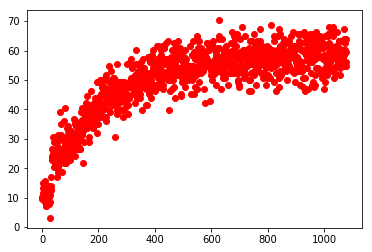

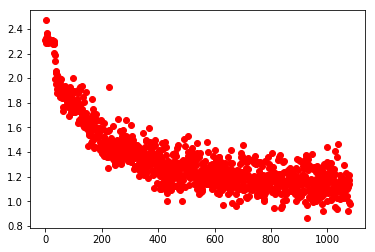

In [1]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'ro')


    plt.figure(2)
    plt.plot(xs, losses, 'ro')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    #parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()

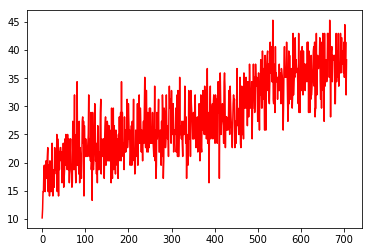

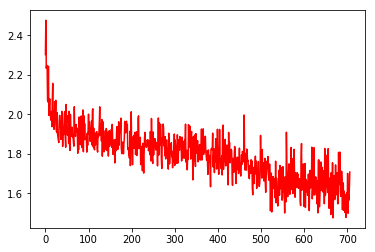

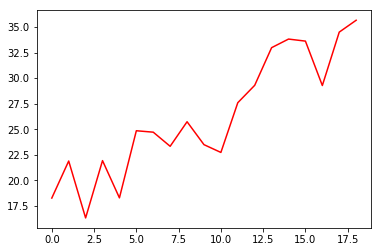

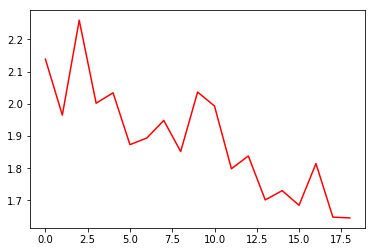

In [3]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'r-')


    plt.figure(2)
    plt.plot(xs, losses, 'r-')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()